# Homework 1: Problem 4: Linear regression in PyTorch
## Predicting home prices with the California housing dataset   

This file contains code that helps you get started on linear regression as a neural network with one input layer with N units corresponding to the number of predictors, and an output layer with one unit. You will implement linear regression to predict the median value of a home in a census block in California from  eight predictor variables. This notebook has already been set up to load this data for you and convert it into a Pandas dataframe. 

In [62]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0,5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data and plotting

We download the California housing dataset, and load it into a pandas dataframe. We have data on median home price in census block groups in California. We want to predict the median home price on the basis of eight numeric predictors at the block group level. 

- MedInc (median income in block group)

- HouseAge (median house age in block group)

- AveRooms (average number of rooms per household)

- AveBedrms (average number of bedrooms per household)

- Population (block group population)

- AveOccup (average number of household members)

- Latitude (block group latitude)

- Longitude (block group longitude)

Before starting on any task, it is often useful to understand the data by visualizing it. For this
dataset, we will show you how to use histograms and scatter plots to visualize the data.

In [63]:
# read the California Housing data and place it in a pandas's dataframe

cdata = fetch_california_housing()
predictors = pd.DataFrame(data = cdata.data, columns = cdata.feature_names)
y = pd.DataFrame(cdata.target,columns = ['price'])
cal_df = pd.concat([predictors,y],axis=1)
cal_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Data visualization
- plot the distribution of the target variable 
    - note that all home prices over 5 are assigned a value of 5.
    - distribution is not Gaussian, right skew with outliers at the high end.
    
- plot the predictor variables
    - AveRooms, AveBedrooms, Population, AveOccupancy have extreme values; the range of values is high, quite a few outliers. Unlikely to be useful predictors, because almost all homes cluster at the very low end of values!
    - MedInc, HouseAge, Latitude, Longitude seem more promising as predictors, with nice distributions.

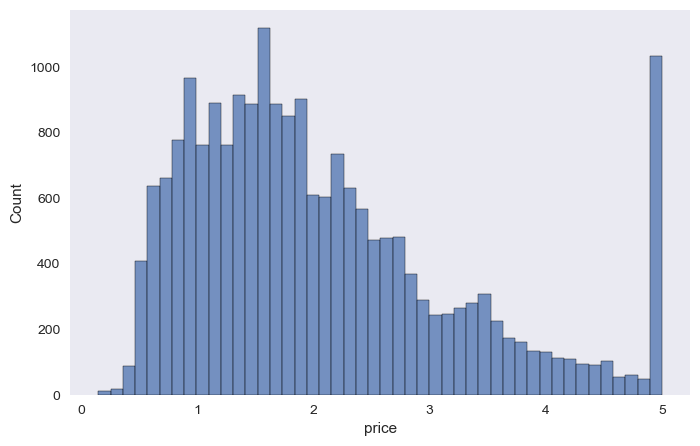

In [64]:
# plot distribution of the target variable
sns.histplot(cal_df['price']);

/var/folders/0b/x5wqvr2j57qc676b_57xh8ww0000gn/T/ipykernel_10236/1888217578.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


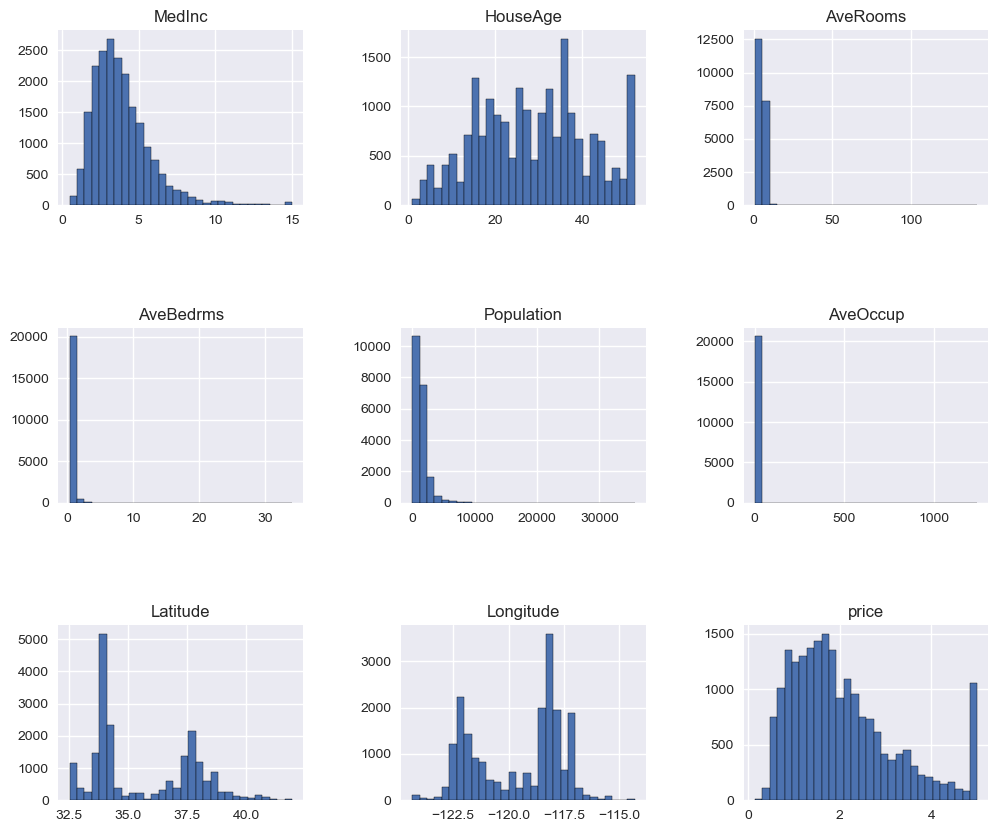

In [65]:
# look at the distributions of the individual predictor variables
plt.style.use('seaborn')

cal_df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

# Spatial visualization
- prices have been discretized by the scatterplot function to simplify the legend.
- most expensive homes are along the coast and in Sacramento, as expected. 
- Latitude and Longitude are very likely to be good predictors of home value. (location, location, location!)


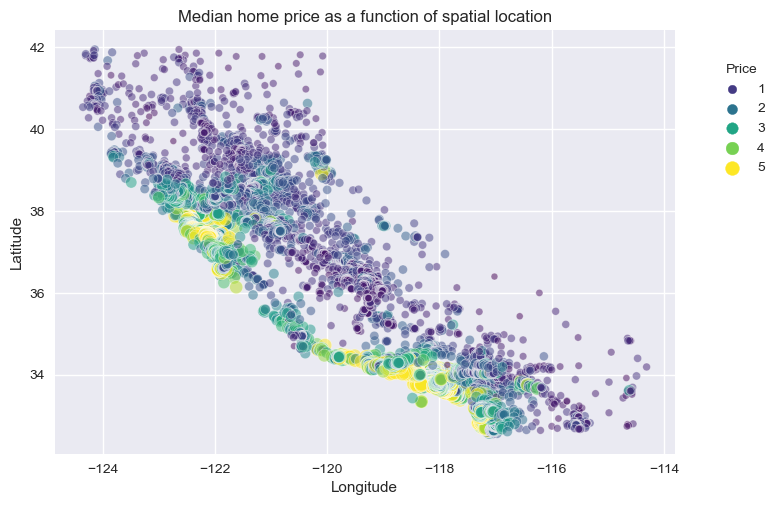

In [66]:
# visualizing the spatial distribution of homes
sns.scatterplot(
    data=cal_df,
    x="Longitude",
    y="Latitude",
    size="price",
    hue="price",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="Price", bbox_to_anchor=(1.05, 0.95), loc="upper left")
plt.title("Median home price as a function of spatial location");

# PyTorch model building (10 points)
- Create the model (Read [3.5.1](https://d2l.ai/chapter_linear-regression/linear-regression-concise.html#defining-the-model))
    - define the network structure: 1 layer network (4 points)
       - set the learning rate lr, and number of inputs num_inputs
       - use [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with num_inputs inputs and one output to set up self.net
       - initialize the weights of network to numbers drawn from a zero-mean normal distribution with std = noise (use self.net.weight.data.normal_(mean,std))
       - initialize bias weight to 0 (use self.net.bias.data.fill_(val))
    - define the forward function (Read 3.5.1) (2 points)
       - propagate the input X through the net
    - define the loss function (mean squared error) (Read 3.5.2) (2 points)
       - [nn.functional.mse_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html)
    - configure the optimizer (Read 3.5.3) (2 points)
       - use [torch.optim.SGD()](https://pytorch.org/docs/stable/optim.html) with self.parameters() and set learning to be the learning rate of the network

In [67]:
class RegressionModel(nn.Module):
    def __init__(self, num_inputs, lr, noise=0.01):
        super(RegressionModel, self).__init__()
        self.num_inputs, self.lr = num_inputs, lr
        self.net = nn.Linear(num_inputs, 1)
        self.weights = self.net.weight.data.normal_(0, noise)
        self.bias = self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X).flatten()
    
    def loss(self, yhat, y):
        return nn.functional.mse_loss(yhat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

## Test your model set up code
- run this code after completing the functions above.
- you should be able to view your model's structure and its weights and bias 

In [68]:
model = RegressionModel(cal_df.shape[1]-1,1)
print(model)
# access model's weights and bias
print(model.net.weight)
print(model.net.bias)

RegressionModel(
  (net): Linear(in_features=8, out_features=1, bias=True)
)
Parameter containing:
tensor([[-0.0024,  0.0013, -0.0005, -0.0006,  0.0067,  0.0085,  0.0169,  0.0056]],
       requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


# Splitting and standardizing training data (6 points)
- split training data (X,y) into a training set (XXtrain,yytrain) and (Xtest,ytest) using sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) (with test_size = 0.2)
- If standardize is True, use sklearn.preprocessing StandardScaler() and fit to XXtrain. Then apply the scaler to transform both XXtrain and Xtest. 
- Split (XXtrain,yytrain) further into (Xtrain,ytrain) and (Xval,yval) using using sklearn's train_test_split (with test_size = 0.2)
- Convert Xtrain,Xval,Xtest,ytrain,yval,ytest into Torch tensors, using [torch.Tensor()](https://pytorch.org/docs/stable/tensors.html)
- Return tensors Xtrain,Xval,Xtest,ytrain,yval,ytest
   - the shapes of the y tensors should be of the form torch.Size([N,1]) [**reshape** if needed]

In [69]:
def make_train_val_test_split(X, y, standardize=True):
    # split X,y into a training and test set in an 80/20 ratio.
    XXtrain, Xtest, yytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=7)
    
    # standardize training and test set if flag is True
    if standardize:
        scaler = StandardScaler()
        scaler.fit(XXtrain)
        XXtrain = scaler.transform(XXtrain)
        Xtest = scaler.transform(Xtest)

    # split the training set further into train and val sets in an 80/20 ratio
    Xtrain, xval, ytrain, yval = train_test_split(XXtrain, yytrain, test_size=0.2, random_state=7)

    # convert train data to tensors
    Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32)
    ytrain_tensor = torch.tensor(ytrain, dtype=torch.float32)

    # convert val data to tensors
    Xval_tensor = torch.tensor(xval, dtype=torch.float32)
    yval_tensor = torch.tensor(yval, dtype=torch.float32)

    # convert test data to tensors
    Xtest_tensor = torch.tensor(Xtest, dtype=torch.float32)
    ytest_tensor = torch.tensor(ytest, dtype=torch.float32)

    return Xtrain_tensor, Xval_tensor, Xtest_tensor, ytrain_tensor, yval_tensor, ytest_tensor

## Test the train/val/test split function
- run the cell below after implementing the function in the previous cell.

In [70]:
X = cal_df.iloc[:,:-1].values # predictor matrix
y = cal_df['price'].values    # target vector

Xtrain_tensor,Xval_tensor,Xtest_tensor,ytrain_tensor,yval_tensor,ytest_tensor = \
        make_train_val_test_split(X,y,standardize=True)
print('Train data: ', Xtrain_tensor.shape, ytrain_tensor.shape)
print('Val data: ', Xval_tensor.shape, yval_tensor.shape)
print('Test data: ', Xtest_tensor.shape, ytest_tensor.shape)

Train data:  torch.Size([13209, 8]) torch.Size([13209])
Val data:  torch.Size([3303, 8]) torch.Size([3303])
Test data:  torch.Size([4128, 8]) torch.Size([4128])


# Train the model
The train function takes the predictor matrix X and the target vector y, the learning rate lr, and the number of epochs, num_epochs,  to train as inputs. Instead of using D2L's trainer class (explained in Section 3.2), we actually write out the training loop explicitly to be able to understand the steps in the training process. Here is the algorithm.

1. Construct tensors Xtrain_tensor,Xval_tensor,Xtest_tensor,ytrain_tensor,yval_tensor,ytest_tensor by calling make_train_val_test_split() with predictor vector X and target vector y (and standardize=True).
2. Set up the model by instantiating RegressionModel with the number of predictors in Xtrain_tensor, and learning rate lr
3. Configure the optimizer for the model by calling the configure_optimizers() method defined in the RegressionModel class.
4. Initialize torch tensors of length num_epochs to store train set loss and val set loss (for plotting)
5. For epoch in range(num_epochs)
   - zero the parameter gradients in the optimizer (use zero_grad())
   - perform a forward pass, and calculate loss on train set (model.loss()). Store train set loss in train set loss tensor.
   - do a backward step to calculate gradients (loss.backward())
   - get the optimizer to take a step in direction of the gradient (optimizer.step())
   - calculate loss on val set and store in val set loss tensor
6. Plot train set loss and val set loss on y-axis and epoch number on x-axis. These are the training curves.
7. return the regression model object, and the Xtest tensor and ytest tensor. The last two are for model evaluation.

In [71]:
def create_train_test_model(X,y,model,num_epochs):
    
    # split into train, val, test sets
    Xtrain_tensor, Xval_tensor, Xtest_tensor, ytrain_tensor, yval_tensor, ytest_tensor = make_train_val_test_split(X, y, standardize=True)

    model = RegressionModel(Xtrain_tensor.shape[1], lr=0.1)
    
    # configure optimizer for model
    optimizer = model.configure_optimizers()

    # initialize train loss and val loss tensors for for plotting
    train_set_loss = torch.zeros(num_epochs)
    val_set_loss = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
       # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize step
        fpass = model.forward(Xtrain_tensor)
        loss = model.loss(fpass, ytrain_tensor)
        train_set_loss[epoch] = loss
        loss.backward()
        optimizer.step()
        
        # calculate and store train loss and val loss for the epoch
        with torch.no_grad():
            fpass = model.forward(Xval_tensor)
            loss = model.loss(fpass, yval_tensor)
            val_set_loss[epoch] = loss
        

    # plot train set loss and val set loss as a function of epoch
    plt.plot(range(num_epochs), train_set_loss.tolist(), label="Train Loss")
    plt.plot(range(num_epochs), val_set_loss.tolist(), label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
 
    # print values of train set loss and val set loss on the last epoch
    print(f"Final Train Loss: {train_set_loss[-1]}")
    print(f"Final Validation Loss: {val_set_loss[-1]}")
    
    return model,Xtest_tensor,ytest_tensor

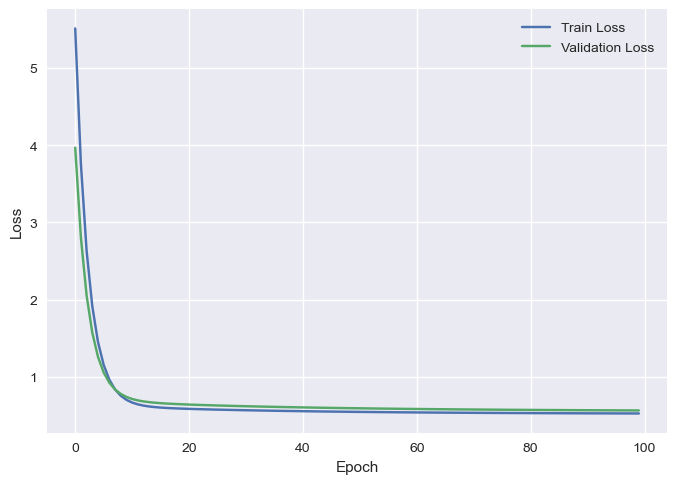

Final Train Loss: 0.5238381028175354
Final Validation Loss: 0.5631163120269775


In [72]:
model, Xtest_tensor, ytest_tensor = create_train_test_model(X, y, model, 100)

# Analyze model performance (10 points)
- get histogram of errors (actual price - predicted price) on set aside test data (Xtest_tensor,ytest_tensor) (3 points)
- get scatterplot of actual price vs predicted price on set aside test data (3 points)
- compute R2 of concordance between actual and predicted values using sklearn.metrics [r2_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) function. (4 points)

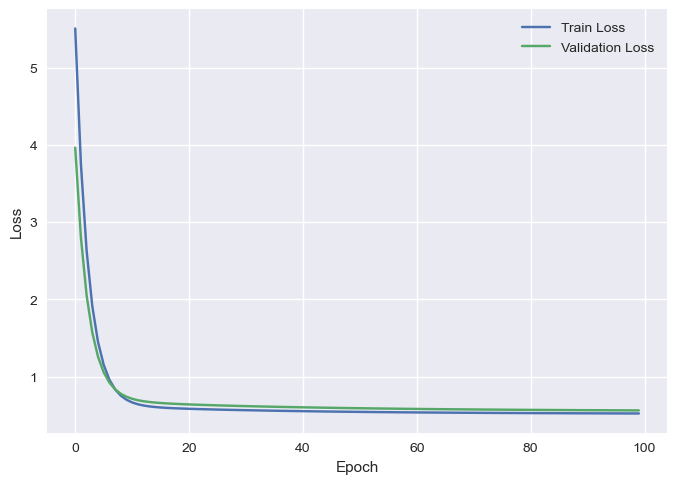

Final Train Loss: 0.5237507820129395
Final Validation Loss: 0.5634045600891113


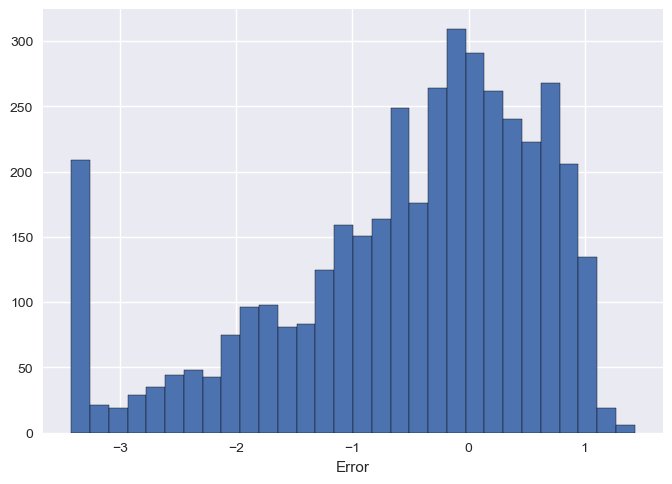

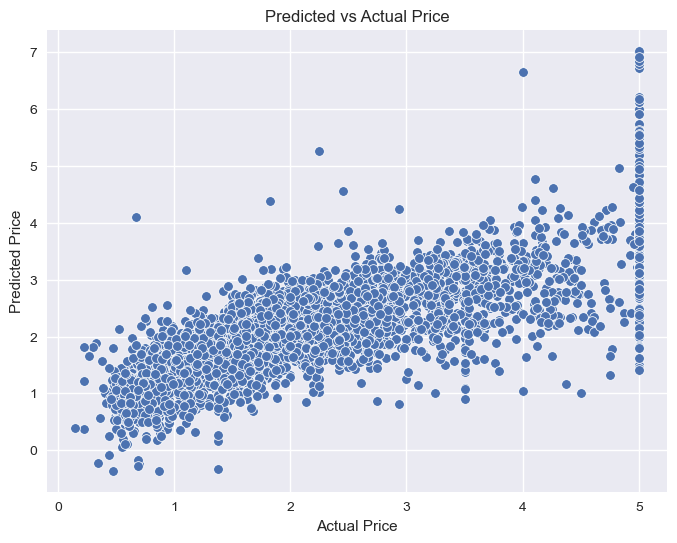

R2 Score: 0.598423111010823


In [73]:
# error distribution on test data (2 lines)
model, Xtest_tensor, ytest_tensor = create_train_test_model(X, y, model, 100)
with torch.no_grad():
    output = model.forward(Xtest_tensor)
    error = output - ytest_tensor.view(-1, 1)

error = [value[0] for value in error]

# plot hisogram (3 lines)
plt.hist(error, bins=30, edgecolor="black")
plt.xlabel("Error")
plt.show()

# scatter plot of predicted vs actual price (4 lines)
output_np = output.numpy()  
ytest_np = ytest_tensor.view(-1, 1).numpy()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=ytest_np.flatten(), y=output_np.flatten()) 
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Predicted vs Actual Price")
plt.show()
    
# assess model quality using r2 (1 line)
print(f"R2 Score: {metrics.r2_score(ytest_np, output_np)}")



# Visualize model parameters
- run code in the following two cells

In [74]:
# Model parameters
print('Model weights:', model.net.weight)
print('Model bias:', model.net.bias)

Model weights: Parameter containing:
tensor([[ 0.8192,  0.1430, -0.1874,  0.2103,  0.0047, -0.0276, -0.6828, -0.6474]],
       requires_grad=True)
Model bias: Parameter containing:
tensor([2.0544], requires_grad=True)


<Axes: >

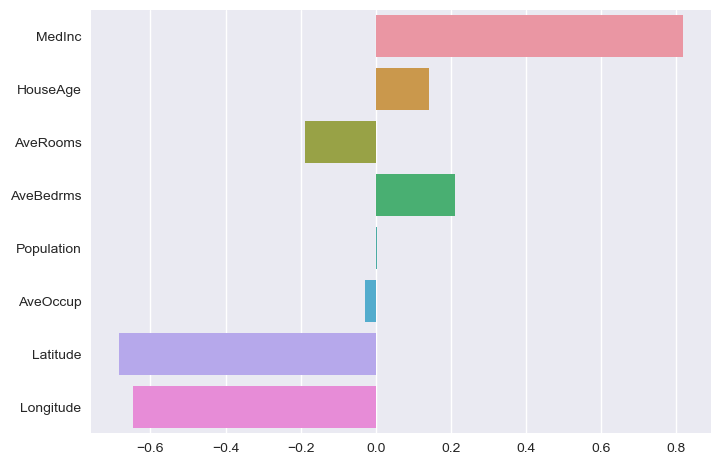

In [75]:
# plot model coefficients
coefs = pd.DataFrame(model.net.weight.data.detach().numpy(),columns=cal_df.columns[:-1])
sns.barplot(y=coefs.columns, x=coefs.iloc[0].values,orient='h')

# Cross-validation to assess model quality (10 points + 10 points)

Up to now, we have assessed model quality with a single train/test split. Now we use a more systematic approach based on 5-fold crossvalidation.  The $R^2$ value is used as a measure of model quality. The closer $R^2$ is to 1., the better the model is. 

In [76]:
# useful for cross-validation, here we split the train folds into a train set and a validation set and 
# a test set 
# train_index and test_index are indices of examples in (X,y) that are in training set and test set 
# (generated by the split function on sklearn's KFold)

def make_train_val_test_cv_split(X,y,train_index,test_index,standardize=True):
    
    # construct the training and test subsets of X,y (2 lines) using the indices
    XXtrain, Xtest = X[train_index], X[test_index]
    yytrain, ytest = y[train_index], y[test_index]
    
    # if standardize flag is set, fit a Standard Scaler on training data and transform the 
    # training and test X (3 lines)
    if standardize:
        scaler = StandardScaler()
        XXtrain = scaler.fit_transform(XXtrain)
        Xtest = scaler.transform(Xtest)

    # split the training X,y set into train and val sets (1 line)
    Xtrain, xval, ytrain, yval = train_test_split(XXtrain, yytrain, test_size=0.2, random_state=7)
    
    # convert train data to tensors (2 lines)
    Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32)
    ytrain_tensor = torch.tensor(ytrain, dtype=torch.float32)

    # convert val data to tensors (2 lines)
    Xval_tensor = torch.tensor(xval, dtype=torch.float32)
    yval_tensor = torch.tensor(yval, dtype=torch.float32)

    # convert test data to tensors (2 lines)
    Xtest_tensor = torch.tensor(Xtest, dtype=torch.float32)
    ytest_tensor = torch.tensor(ytest, dtype=torch.float32)
    
    return Xtrain_tensor,Xval_tensor,Xtest_tensor,ytrain_tensor,yval_tensor,ytest_tensor


# Training in crossvalidation mode 

X,y are predictor matrix and target vector. K is the number of crossvalidation folds. Models is a list of length K of regression model objects. num_epochs is the number of epochs to train each model

1. Create a KFold() object called kfolds with n_splits = K
2. For (train_index,test_index) in kfolds.split(X)

   - Construct tensors Xtrain_tensor,Xval_tensor,Xtest_tensor,ytrain_tensor,yval_tensor,ytest_tensor by calling make_train_val_test_split() with predictor vector X and target vector y (and standardize=True).
   - Extract model from models for that fold
   - Configure the optimizer for the model for that fold by calling the configure_optimizers() method defined in the RegressionModel class.
   - Initialize torch tensors of length num_epochs to store train set loss and val set loss (for plotting)
   - For epoch in range(num_epochs)
       - zero the parameter gradients in the optimizer (use zero_grad())
       - perform a forward pass, and calculate loss on train set (model.loss()). Store train set loss in train set loss tensor.
       - do a backward step to calculate gradients (loss.backward())
       - get the optimizer to take a step in direction of the gradient (optimizer.step())
       - calculate loss on val set and store in val set loss tensor
   - Plot train set loss and val set loss on y-axis and epoch number on x-axis. These are the training curves for that fold.
3. return the regression models list, and the Xtest tensor and ytest tensor. The last two are for model evaluation.

In [77]:
def create_train_test_cv_model(X,y,K,models,num_epochs):
    
    # make the kfolds object by calling sklearn's KFold with parameter K
    kfolds = KFold(n_splits=K)
    
    # for every fold
    count = 0
    for (train_index,test_index) in kfolds.split(X):
    
        # split into train, val, test sets (1 line)
        Xtrain_tensor,Xval_tensor,Xtest_tensor,ytrain_tensor,yval_tensor,ytest_tensor = \
        make_train_val_test_cv_split(X,y,train_index,test_index,standardize=True)
        
      
        # extract model for that fold from list of models (2 lines)
        # set up optimizer
        kfolds_model = models[count]
        count += 1
        optimizer = kfolds_model.configure_optimizers()
        
        # initialize train_loss and val_loss tensors (2 lines)
        train_set_loss = torch.zeros(num_epochs)
        val_set_loss = torch.zeros(num_epochs)

        # Training loop
        for epoch in range(num_epochs):
            # zero the parameter gradients (1 line)
            optimizer.zero_grad()

            # forward + backward + optimize (4 lines)
            fpass = kfolds_model.forward(Xtrain_tensor)
            loss = kfolds_model.loss(fpass, ytrain_tensor)
            train_set_loss[epoch] = loss
            
            # calculate and store train and val loss for that epoch (2 lines)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                fpass = kfolds_model.forward(Xval_tensor)
                loss = kfolds_model.loss(fpass, yval_tensor)
                val_set_loss[epoch] = loss
            
        # plot train loss and val loss curves for that fold (2 lines)
        plt.plot(range(num_epochs), train_set_loss.tolist(), label="Train Loss")
        plt.plot(range(num_epochs), val_set_loss.tolist(), label="Validation Loss")
        
        # print final train and val loss for that fold (2 lines)
        print(f"Final Train Loss: {train_set_loss[-1]}")
        print(f"Final Validation Loss: {val_set_loss[-1]}")
        
    return models,Xtest_tensor,ytest_tensor

## Test your crossvalidation trainer
- run the cell below after completing the two functions above

Final Train Loss: 0.5554741024971008
Final Validation Loss: 0.5375845432281494
Final Train Loss: 0.5124052166938782
Final Validation Loss: 0.48613232374191284
Final Train Loss: 0.5130967497825623
Final Validation Loss: 0.46855100989341736
Final Train Loss: 0.5385544896125793
Final Validation Loss: 0.505572497844696
Final Train Loss: 0.5535796880722046
Final Validation Loss: 0.5081269145011902


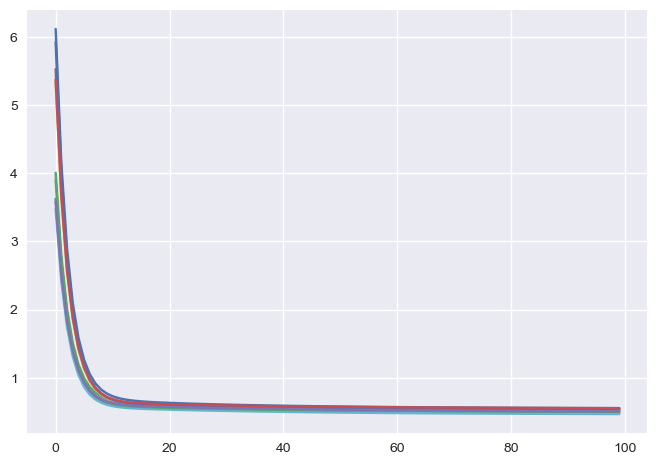

In [78]:
X = cal_df.iloc[:,:-1].values # predictor matrix
y = cal_df['price'].values    # target vector
K = 5
lr = 0.1
num_epochs = 100

models = [RegressionModel(Xtrain_tensor.shape[1],lr=lr) for i in range(K)]

models,Xtest_tensor,ytest_tensor = create_train_test_cv_model(X,y,K,models,num_epochs)

# Assessing crossvalidation performance

In [79]:
# assess model quality using r2 on test data on all K models
r2_scores = []
count = 0
for model in models:
    count += 1
    with torch.no_grad():
        output = model.forward(Xtest_tensor)

    output_np = output.numpy()  
    ytest_np = ytest_tensor.view(-1, 1).numpy()
    # assess model quality using r2 (1 line)
    r2_score = metrics.r2_score(ytest_np, output_np)
    r2_scores.append(r2_score)
    print(f"R2 Score - Model {count}: {r2_score}")

# report mean and std on r2 (4 lines)
print(f"R2 Scores - Mean: {np.mean(r2_scores)}")
print(f"R2 Scroes - Std: {np.std(r2_scores)}")

R2 Score - Model 1: 0.639739065726609
R2 Score - Model 2: 0.6673575679466722
R2 Score - Model 3: 0.6644793891276999
R2 Score - Model 4: 0.6558937417518327
R2 Score - Model 5: 0.6503337651379155
R2 Scores - Mean: 0.6555607059381459
R2 Scroes - Std: 0.009964587146986847


# Visualizing coefficients of CV models
- run the cell below to visualize your model coefficients

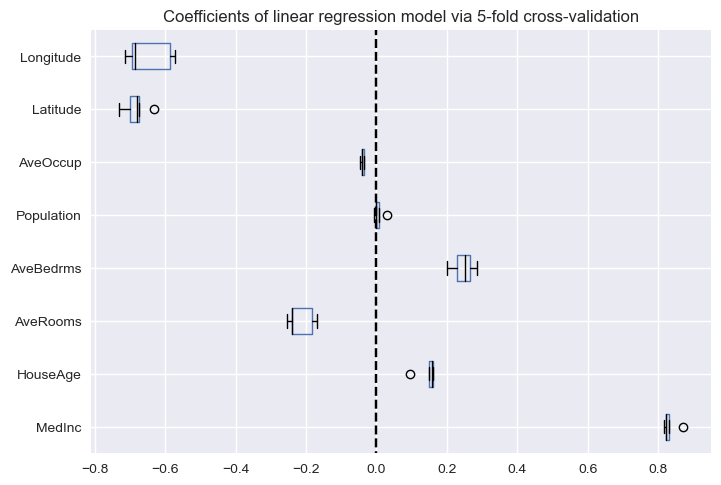

In [80]:
coefs = pd.DataFrame()
for i in range(K):
    coef = pd.DataFrame(models[i].net.weight.data.detach().numpy(),columns=cal_df.columns[:-1])
    coefs = pd.concat([coefs,coef],axis=0)
coefs = coefs.reset_index(drop=True)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
coefs.plot.box(vert=False, color=color)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
_ = plt.title("Coefficients of linear regression model via 5-fold cross-validation")

# Adding weight decay and polynomial basis function expansion
- define a new class RegressionModelL2 by copying the RegressionModel class and adding a new argument to the init function: wd (for weight decay or lambda)
- fill in the methods below
- you need to modify the torch.optim.SGD call to include weight_decay (see [3.7](https://d2l.ai/chapter_linear-regression/weight-decay.html#concise-implementation))
- 5 points for the class definition below

In [81]:
class RegressionModelL2(nn.Module):
    def __init__(self, num_inputs,  lr, noise=0.01,wd=0.1):
        super(RegressionModelL2, self).__init__()
        self.num_inputs, self.lr = num_inputs, lr
        self.net = nn.Linear(num_inputs, 1)
        self.weights = self.net.weight.data.normal_(0, noise)
        self.bias = self.net.bias.data.fill_(0)
        self.wd = wd

    def forward(self, X):
        # your code here (1 line)
        return self.net(X).flatten()
    
    def loss(self,yhat,y):
        # your code here (1 line)
        return self.loss(yhat,y)
    
    def configure_optimizers(self):
        # your code here (1 line)
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.wd)
           

# Set up L2 regression model and train using a simple train/val/test split
- 5 points for running the code below and assessing model quality as a function of the value of wd
- try different values of wd and see its impact on r2 as well as on the coefficient magnitudes and signs

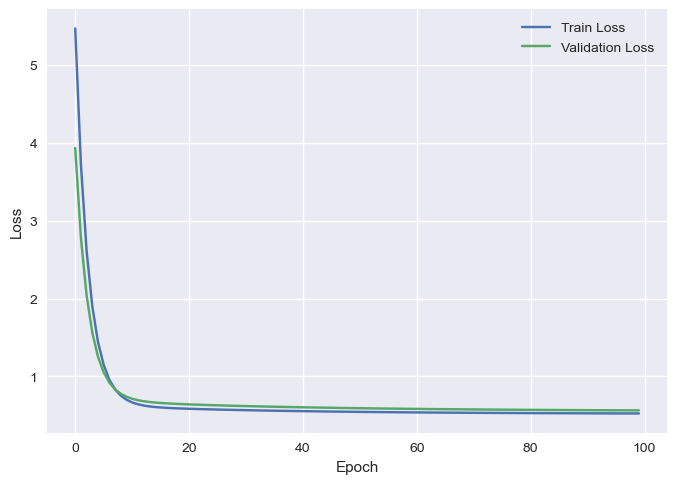

Final Train Loss: 0.5237771272659302
Final Validation Loss: 0.5633402466773987


In [82]:
X = cal_df.iloc[:,:-1].values # predictor matrix
y = cal_df['price'].values    # target vector
lr = 0.1
num_epochs = 100
wd = 0.01

l2_model = RegressionModelL2(X.shape[1],lr=lr,wd=wd)
l2_model,Xtest_tensor,ytest_tensor = create_train_test_model(X,y,l2_model,num_epochs)

In [83]:
# assess model quality using r2 (1 line)
print(f"R2 Score: {metrics.r2_score(ytest_tensor, l2_model.forward(Xtest_tensor).detach().numpy())}")

R2 Score: 0.5984424317728869


<Axes: >

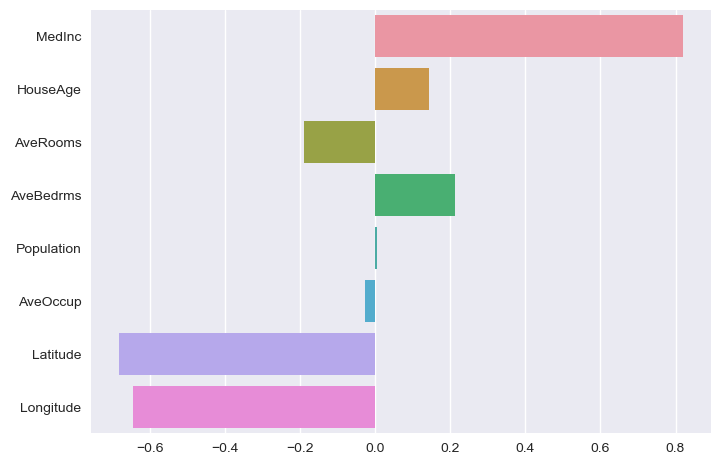

In [84]:
# plot model coefficients
coefs = pd.DataFrame(l2_model.net.weight.data.detach().numpy(),columns=cal_df.columns[:-1])
sns.barplot(y=coefs.columns, x=coefs.iloc[0].values,orient='h')

# Polynomial basis function expansion
- use sklearn [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) 
- 5 points for the code in this cell

In [85]:
from sklearn.preprocessing import PolynomialFeatures

X = cal_df.iloc[:,:-1]        # predictor matrix
y = cal_df['price'].values    # target vector

# make a PolynomialFeatures constructor (make include_bias = False) for polynomial of degree 2 
# fit and transform X using that constructor, call that Xpoly
# (2 lines)
poly = PolynomialFeatures(degree=2, include_bias=False)
Xpoly = poly.fit_transform(X)

# get the feature names associated with Xpoly using the method [get_feature_names_out](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) of the constructor
# print the shape Xpoly
# print the feature names
print(Xpoly.shape)
Xpoly_cols = poly.get_feature_names_out(X.columns)
print(Xpoly_cols)

(20640, 44)
['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude' 'MedInc^2' 'MedInc HouseAge' 'MedInc AveRooms'
 'MedInc AveBedrms' 'MedInc Population' 'MedInc AveOccup'
 'MedInc Latitude' 'MedInc Longitude' 'HouseAge^2' 'HouseAge AveRooms'
 'HouseAge AveBedrms' 'HouseAge Population' 'HouseAge AveOccup'
 'HouseAge Latitude' 'HouseAge Longitude' 'AveRooms^2'
 'AveRooms AveBedrms' 'AveRooms Population' 'AveRooms AveOccup'
 'AveRooms Latitude' 'AveRooms Longitude' 'AveBedrms^2'
 'AveBedrms Population' 'AveBedrms AveOccup' 'AveBedrms Latitude'
 'AveBedrms Longitude' 'Population^2' 'Population AveOccup'
 'Population Latitude' 'Population Longitude' 'AveOccup^2'
 'AveOccup Latitude' 'AveOccup Longitude' 'Latitude^2'
 'Latitude Longitude' 'Longitude^2']


(20640, 20)


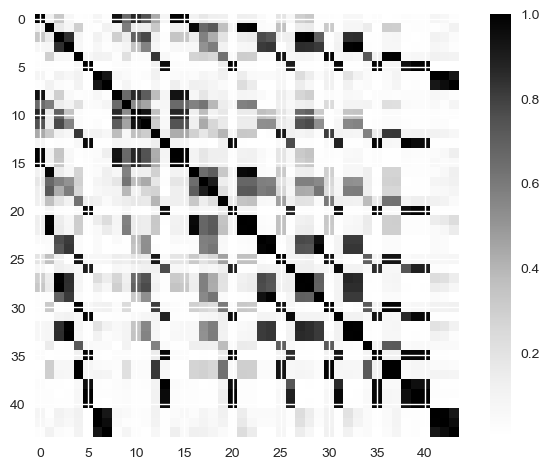

In [86]:
# understand the correlation structure of Xpoly
Xdf = pd.DataFrame(Xpoly,columns=Xpoly_cols)
corr_matrix = Xdf.corr().abs()
plt.imshow(corr_matrix)
plt.rcParams['axes.grid'] = False
plt.colorbar()

# drop the features that have correlations greater than 0.95 with other predictive features
# get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop highly correlated features
Xdf.drop(to_drop, axis=1, inplace=True)
print(Xdf.shape)

# now Xdf has just the selected features for model building

# Train the L2 model with the selected features (15 points)
- run the cell below
- try different weights for wd and assess the effect on model coefficients and model performance
- what is the best setting for wd?
- also test variation with changes in lr and num_epochs
- does the model with expanded basis functions do better than the one without? Why or why not?

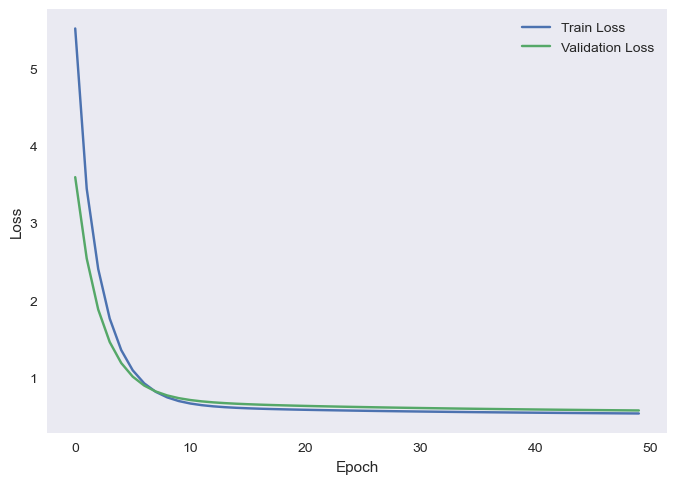

Final Train Loss: 0.5393858551979065
Final Validation Loss: 0.5784046053886414


In [87]:
lr = 0.1
num_epochs = 50
wd = 0.1

l2_model = RegressionModelL2(Xdf.shape[1],lr=lr,wd=wd)
l2_model,Xtest_tensor,ytest_tensor = create_train_test_model(Xdf,y,l2_model,num_epochs)

In [88]:
# compute r2 score for l2_model after training (1 line)
print(f"R2 Score: {metrics.r2_score(ytest_tensor, l2_model.forward(Xtest_tensor).detach().numpy())}")

R2 Score: 0.5881187581367806


<Axes: >

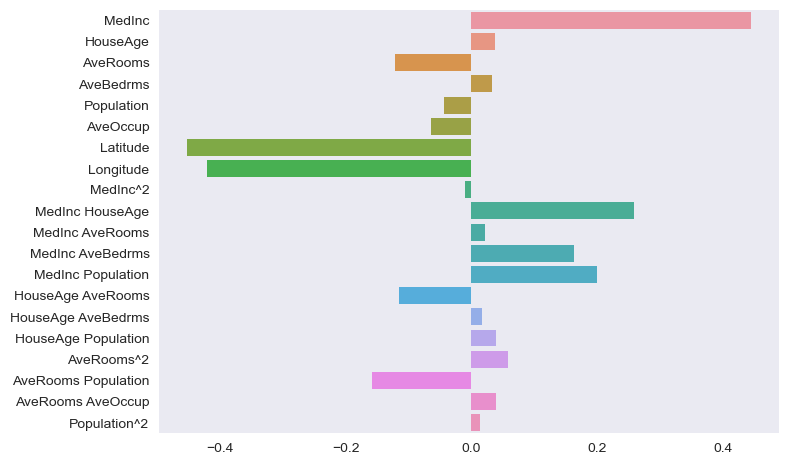

In [89]:
# plot model coefficients
coefs = pd.DataFrame(l2_model.net.weight.data.detach().numpy(),columns=Xdf.columns)
sns.barplot(y=coefs.columns, x=coefs.iloc[0].values,orient='h')

# Congratulations! You have built unregularized and L2 regularized models in PyTorch.
- Please leave all code and plots in this notebook and upload onto Gradescope.